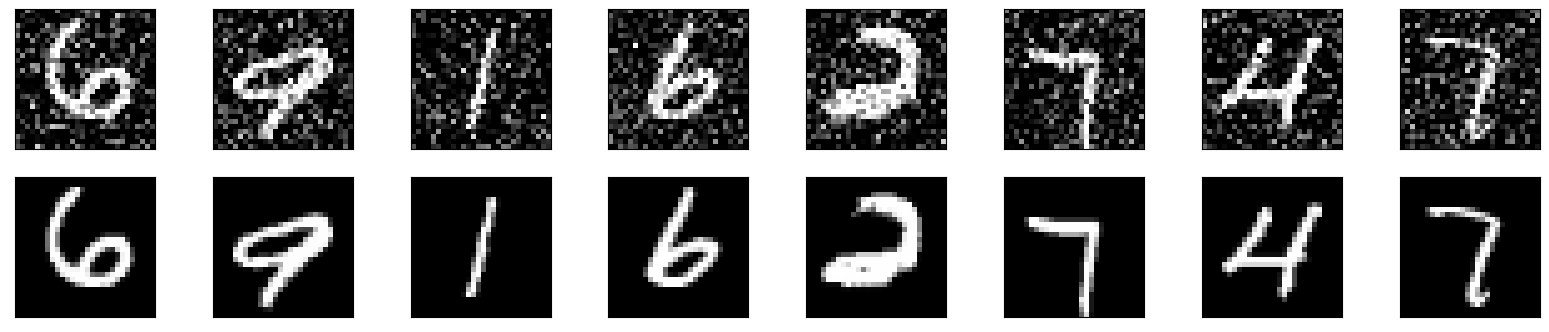

2023-01-04 11:53:33.041309: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-01-04 11:53:33.041952: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch: 0


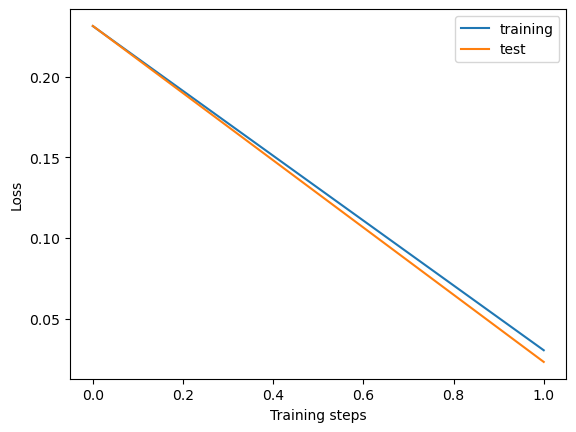

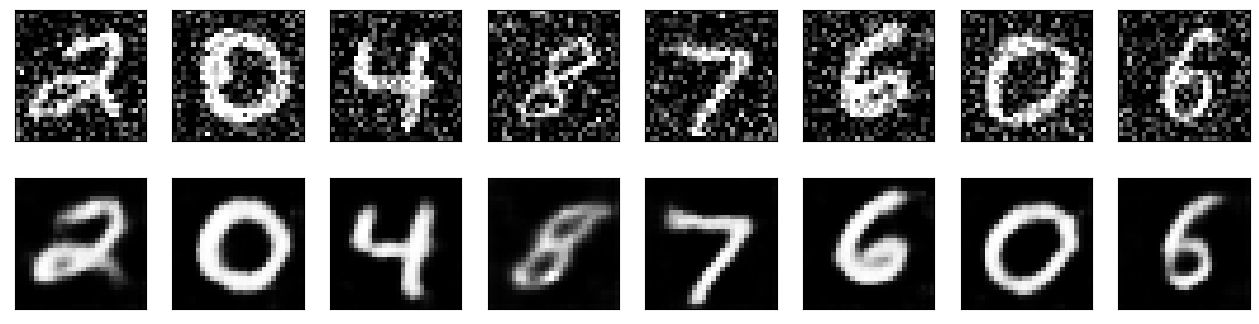

Epoch: 1


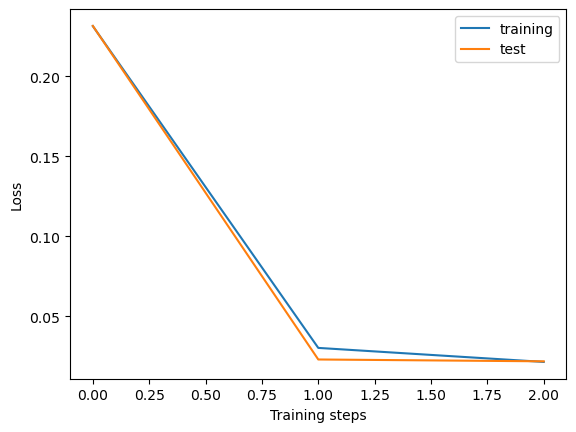

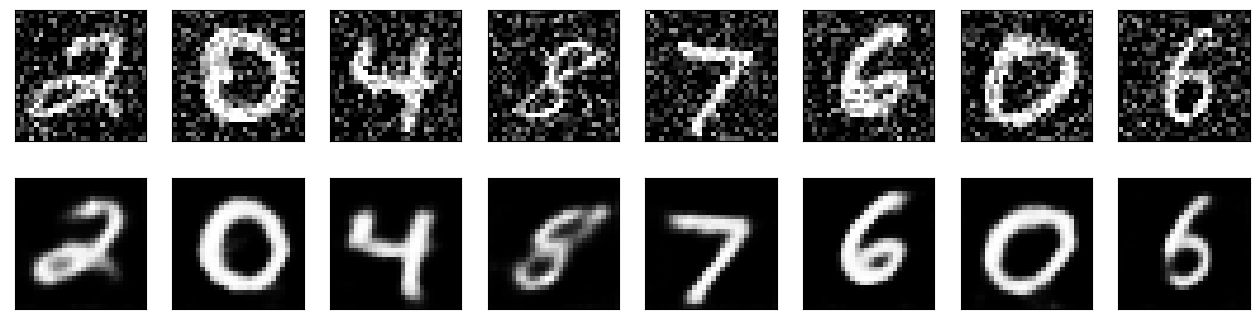

Epoch: 2


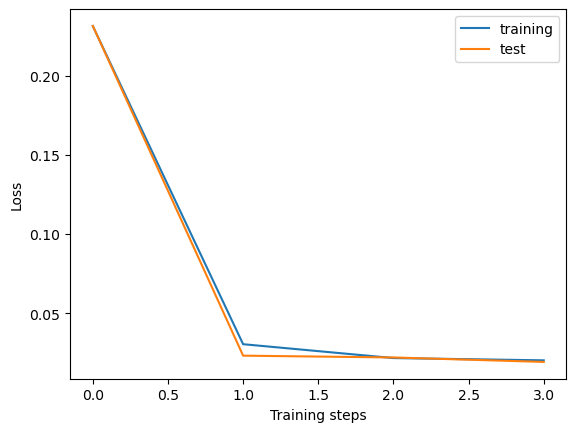

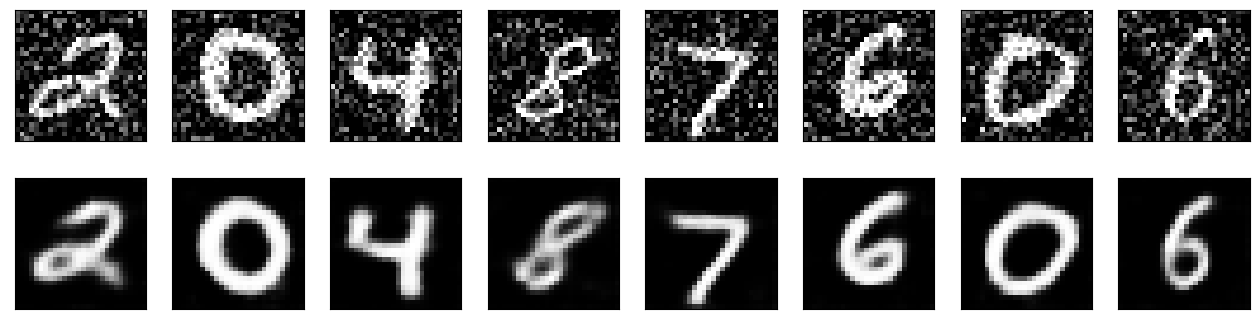

Epoch: 3


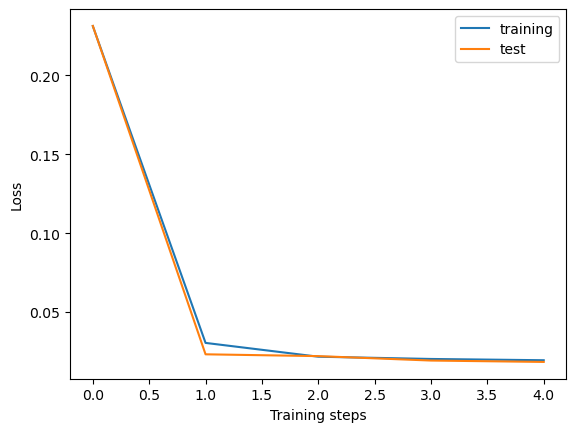

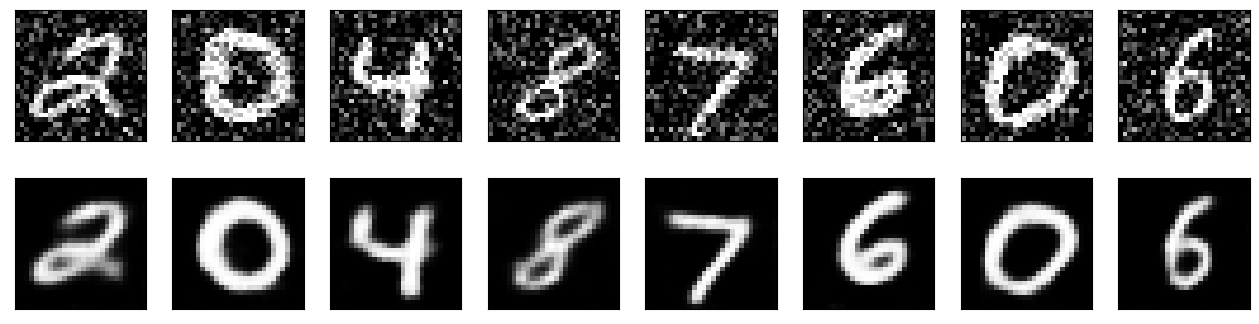

Epoch: 4


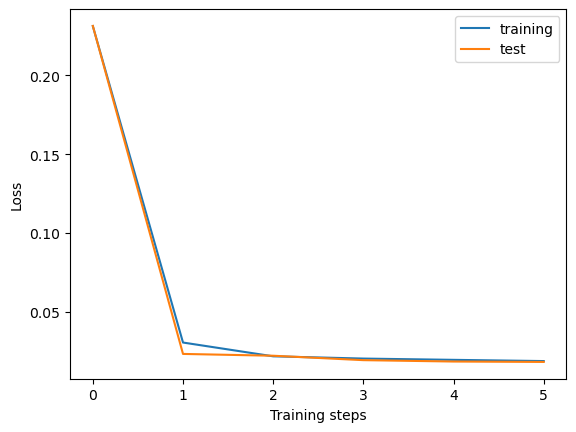

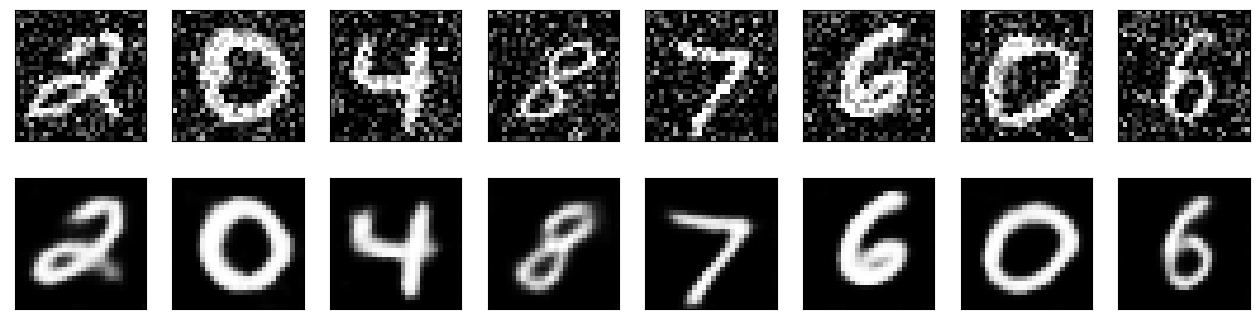

Model: "autoencoder_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_4 (Encoder)         multiple                  9894472   
                                                                 
 decoder_4 (Decoder)         multiple                  96833     
                                                                 
Total params: 9,991,305
Trainable params: 9,978,377
Non-trainable params: 12,928
_________________________________________________________________
32/32 [==============================] - 0s 8ms/step
Epoch: 0


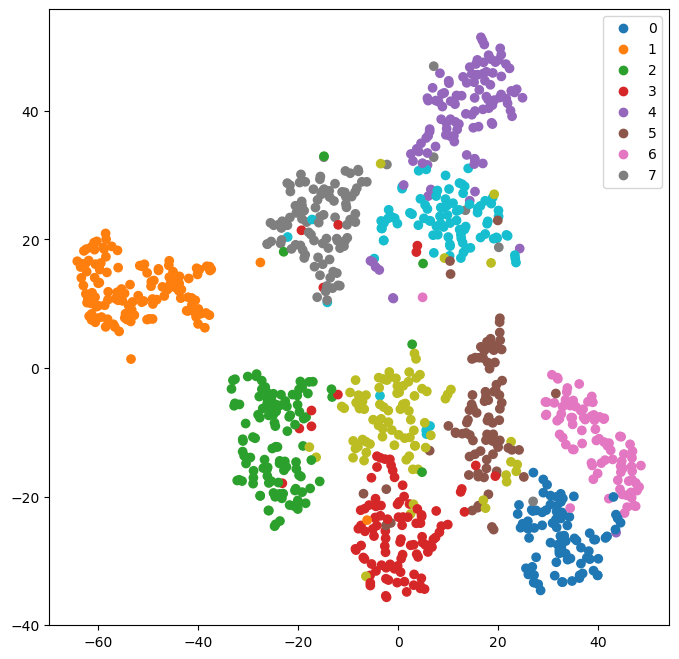

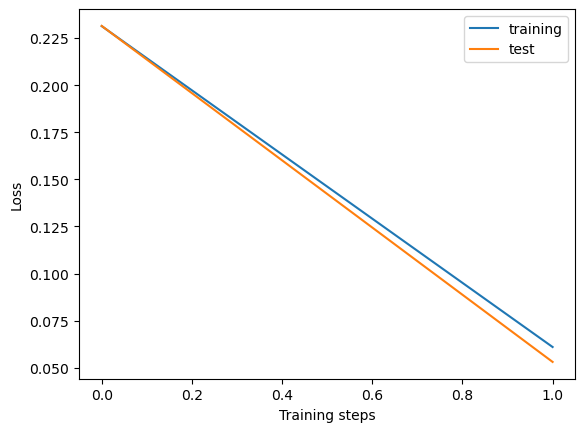

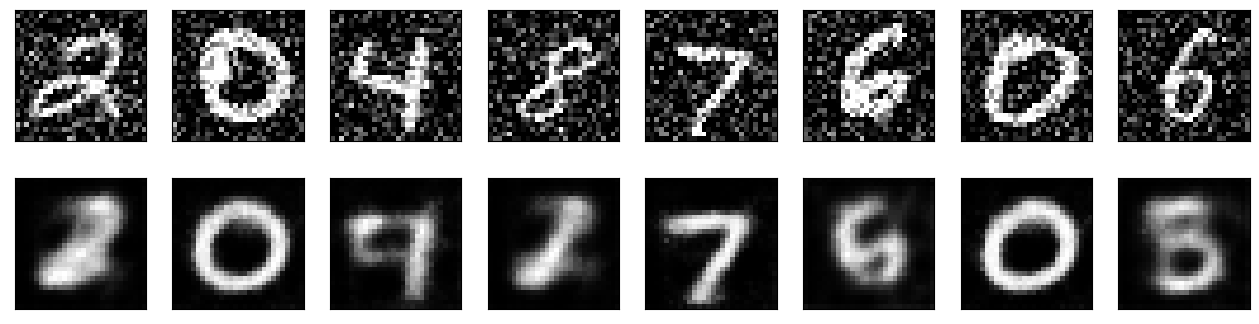

Epoch: 1


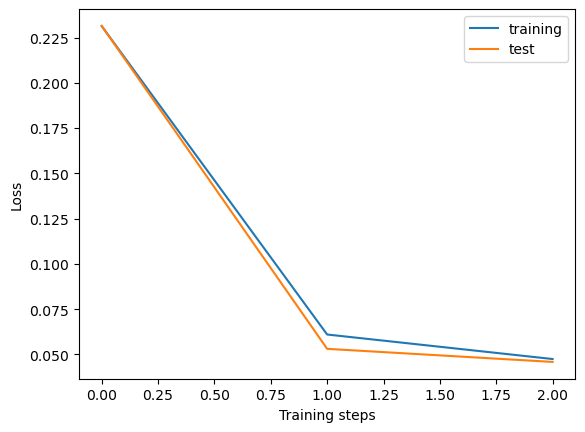

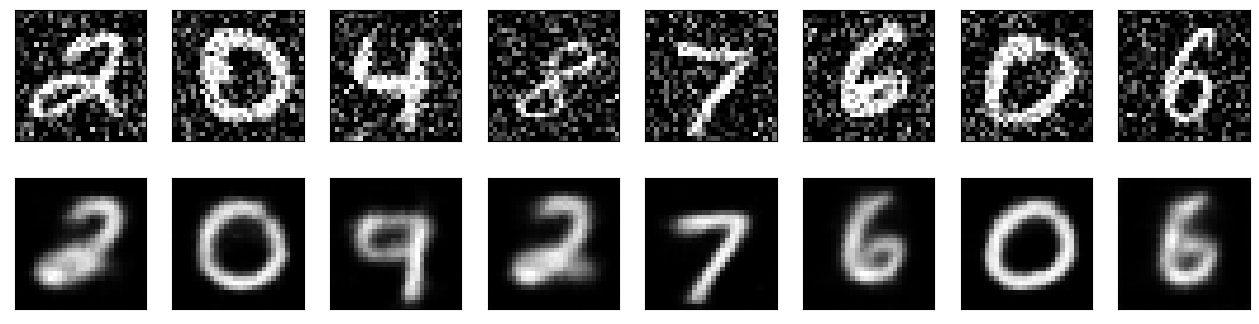

Epoch: 2


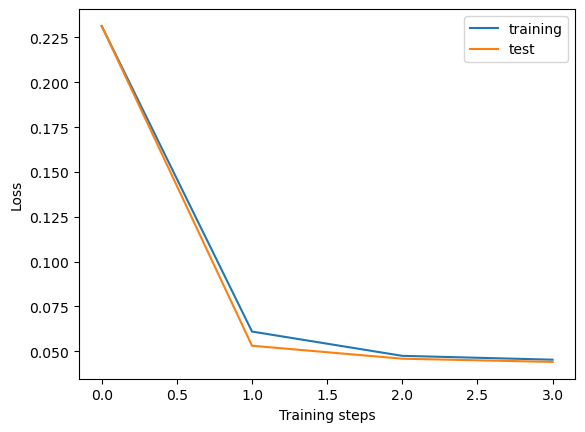

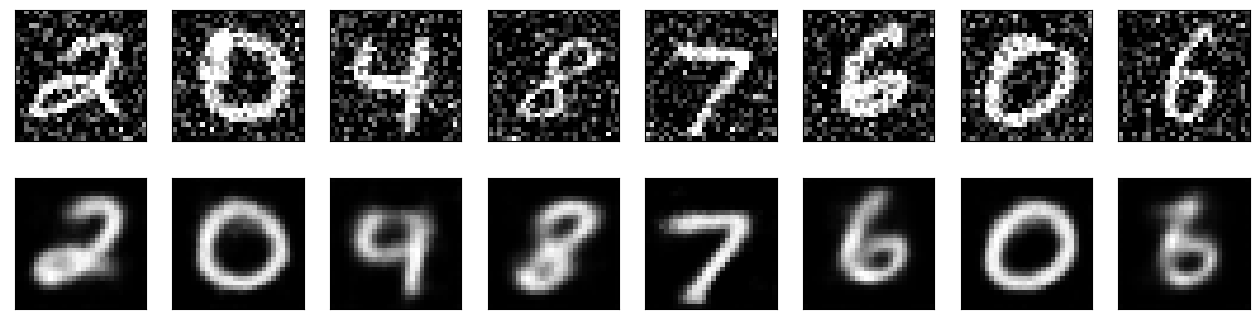

Epoch: 3


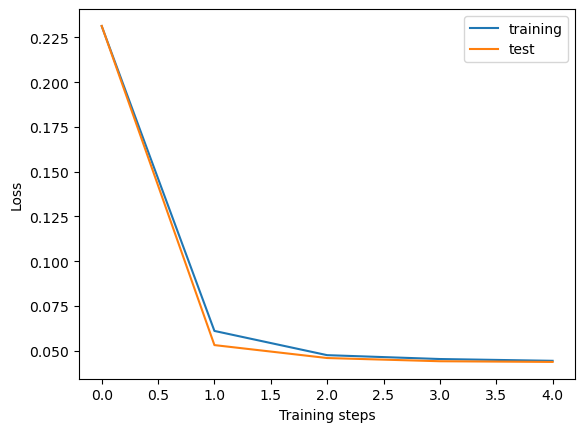

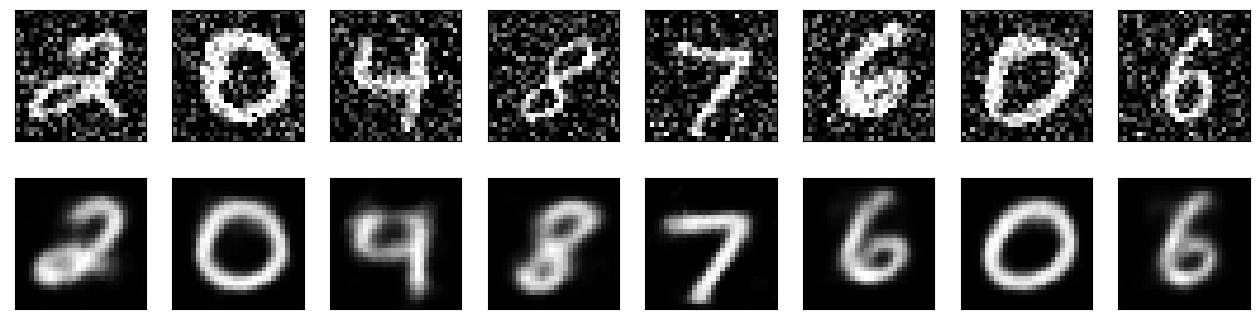

Epoch: 4


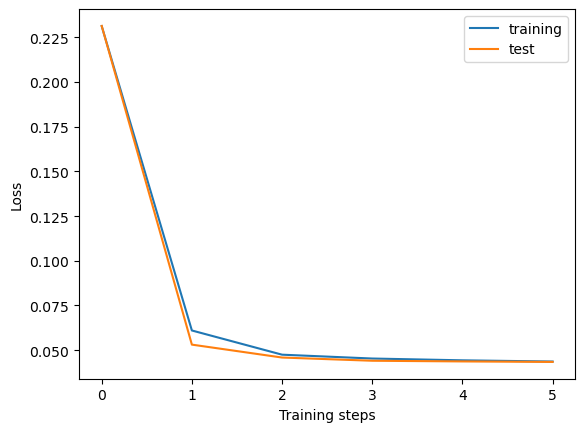

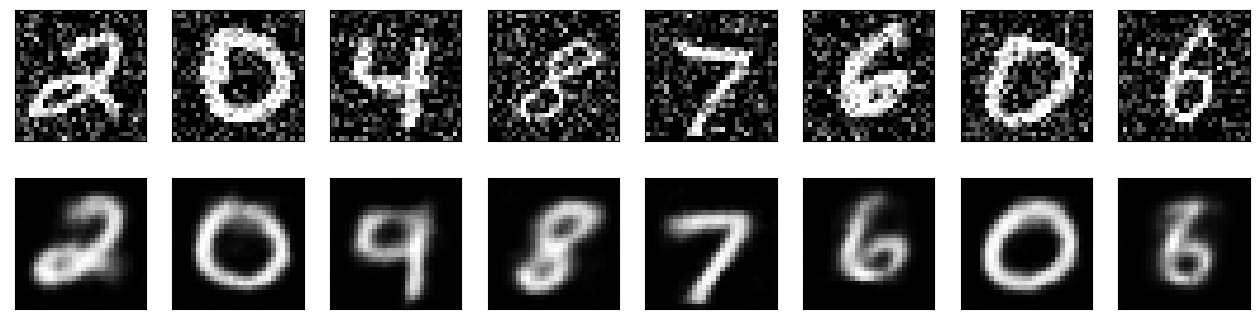

32/32 [==============================] - 0s 7ms/step


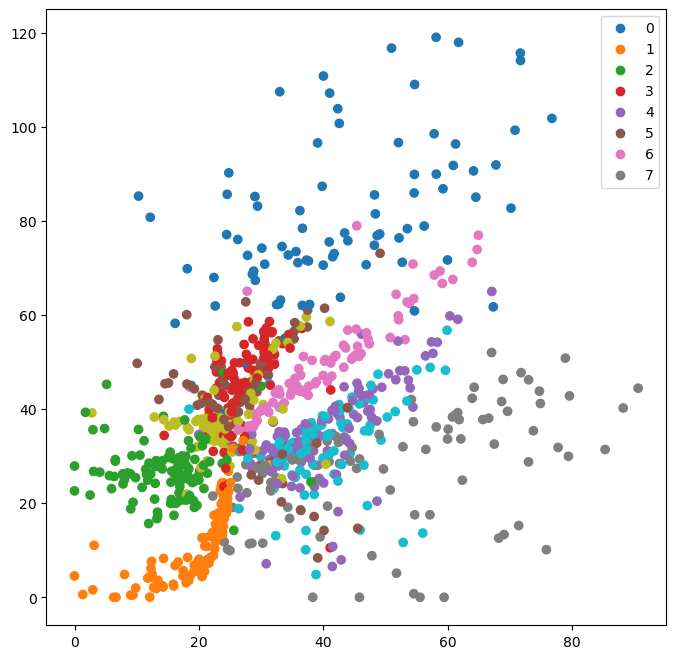

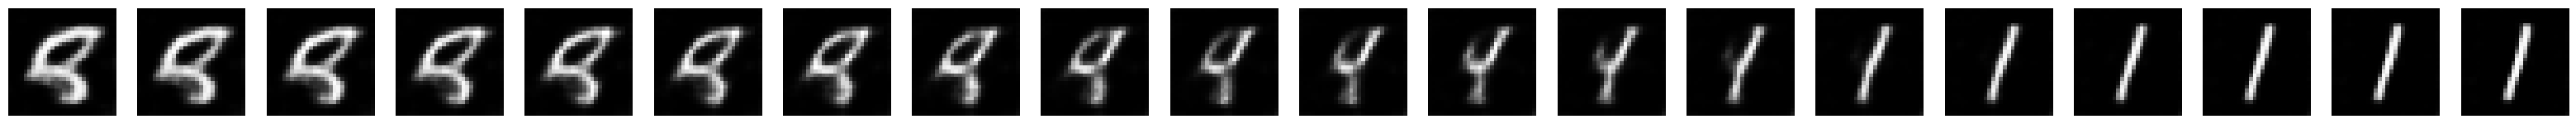

In [6]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

train_ds, test_ds = tfds.load(
    "mnist", split=["train", "test"], as_supervised=True
)
test_imgs = test_ds.take(8)


def prepare_data(data, noise: float = 0.3):
    # convert data 
    data = data.map(lambda img, target: tf.cast(img, tf.float32))
    
    # sloppy input normalization
    data = data.map(lambda img: img / 255)
    
    # Add noise,create target vector
    data = data.map(
        lambda img: (
            img
            + tf.random.normal(shape=img.shape, mean=0.0, stddev=1.0 * noise),
            img,
        )
    )
    # Scaling noisy image
    data = data.map(
        lambda img, target: (
            tf.clip_by_value(img, clip_value_min=0, clip_value_max=1),
            target,
        )
    )
    return data


def prepare_mnist_data(mnist):
    mnist = mnist.apply(prepare_data)
    

    mnist = mnist.cache()
    
    # shuffle, batch, prefetch
    mnist = mnist.shuffle(1000)
    mnist = mnist.batch(64)
    mnist = mnist.prefetch(8)
    
    return mnist


train_ds = train_ds.apply(prepare_mnist_data)
test_ds = test_ds.apply(prepare_mnist_data)
test_imgs = (
    test_imgs.apply(prepare_data)
    .map(lambda img, target: img)
    .map(lambda img: tf.expand_dims(img, 0))
)

for x, t in train_ds:
    n = 8  
    plt.figure(figsize=(20, 4))
    for i in range(n):
        
        # show noisy image
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(tf.squeeze(x[i]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # show reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(tf.squeeze(t[i]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    break


#Model and Autoencoder

class Encoder(tf.keras.Model):
    def __init__(self, latent_dim: int = 8): 
        super(Encoder, self).__init__()

        self.all_layers = [
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=(3, 3), strides=(2, 2), padding="same",
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation(tf.nn.relu),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=(3, 3), strides=(2, 2), padding="same",
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation(tf.nn.relu),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(7 * 7 * 64),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation(tf.nn.relu),
            tf.keras.layers.Dense(latent_dim, activation=tf.nn.relu),
        ]

    @tf.function
    def call(self, x: tf.Tensor, training: bool = False) -> tf.Tensor:

        for layer in self.all_layers:
            try:
                x = layer(x, training=training)
            except:
                x = layer(x)

        return x


from tensorflow.python.ops.gen_math_ops import sigmoid


class Decoder(tf.keras.Model):
    def __init__(self):
        super(Decoder, self).__init__()

        self.all_layers = [
            tf.keras.layers.Dense(7 * 7 * 64),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation(tf.nn.relu),
            tf.keras.layers.Reshape((7, 7, 64)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=(3, 3), strides=(2, 2), padding="same"
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation(tf.nn.relu),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=(3, 3), strides=(2, 2), padding="same"
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation(tf.nn.relu),
            tf.keras.layers.Conv2D(
                filters=1,
                kernel_size=(3, 3),
                strides=(1, 1),
                padding="same",
                activation=tf.nn.sigmoid,
            ),
        ]

    @tf.function
    def call(self, x: tf.Tensor, training: bool = False) -> tf.Tensor:

        for layer in self.all_layers:
            try:
                x = layer(x, training=training)
            except:
                x = layer(x)

        return x


class Autoencoder(tf.keras.Model):
    def __init__(self, latent_dim: int = 8): 
        super(Autoencoder, self).__init__()

        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder()

    @tf.function
    def call(self, inputs: tf.Tensor, training: bool = False) -> tf.Tensor:
        out_encoder = self.encoder(inputs, training=training)
        out_decoder = self.decoder(out_encoder, training=training)

        return out_decoder


autoencoder = Autoencoder()

#train the model
import numpy as np


def train_step(
    model: tf.keras.Model,
    data: tf.Tensor,
    target: tf.Tensor,
    loss_function: tf.keras.losses,
    optimizer: tf.keras.optimizers,
    training: bool = True,
):
 

    with tf.GradientTape() as tape:
        prediction = model(data, training)
        loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss


def test(
    model: tf.keras.Model,
    test_data: tf.Tensor,
    loss_function: tf.keras.losses,
    training: bool = False,
):
  
    test_loss_aggregator = []

    for data, target in test_data:
        prediction = model(data)

        test_loss = loss_function(target, prediction)
        test_loss_aggregator.append(test_loss.numpy())

    test_loss = tf.reduce_mean(test_loss_aggregator)

    return test_loss


def visualization(train_losses, test_losses):
    plt.figure()
    (line1,) = plt.plot(train_losses)
    (line2,) = plt.plot(test_losses)
    plt.xlabel("Training steps")
    plt.ylabel("Loss")
    plt.legend((line1, line2), ("training", "test"))
    plt.show()


def training(
    model: tf.keras.Model,
    train_ds: tf.Tensor,
    test_ds: tf.Tensor,
    num_epochs: int = 5,
    learning_rate: int = 0.001,
):
    loss = tf.keras.losses.MeanSquaredError()
    optimizer = tf.keras.optimizers.Adam(learning_rate)

    
    train_losses: list = []
    test_losses: list = []

    # testing train dataset 
    train_loss = test(model, train_ds, loss)
    train_losses.append(train_loss)

   
    test_loss = test(model, test_ds, loss)
    test_losses.append(test_loss)

   
    for epoch in range(num_epochs):
        print("Epoch: " + str(epoch))

       
        epoch_loss_agg = []
        for inp, target in train_ds:
            train_loss = train_step(
                model, inp, target, loss, optimizer, training=True
            )
            epoch_loss_agg.append(train_loss)

        # training loss
        train_losses.append(tf.reduce_mean(epoch_loss_agg))

       
        test_loss = test(model, test_ds, loss)
        test_losses.append(test_loss)

        visualization(train_losses, test_losses)

        plt.figure(figsize=(20, 4))
        for i, inp in enumerate(test_imgs):
            n = 10
            decoded_img = model(inp)

            # Display noisy image
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(tf.squeeze(inp))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # Display reconstruction
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(tf.squeeze(decoded_img))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        plt.show()


training(model=autoencoder, train_ds=train_ds, test_ds=test_ds)

autoencoder.summary()

#Latent space analysis

from sklearn.manifold import TSNE

label_names = [str(l) for l in np.arange(8)]  
(
    (train_x, train_labels),
    (test_x, test_labels),
) = tf.keras.datasets.mnist.load_data()

img = test_x[:1000]
labels = test_labels[:1000]
img = tf.expand_dims(tf.cast(img, tf.float32) / 255.0, -1)

encoded = autoencoder.encoder.predict(img)
encoded = np.reshape(encoded, (encoded.shape[0], -1))

embedded = TSNE(n_components=2, perplexity=20).fit_transform(encoded)

fig = plt.figure(figsize=(8, 8))  #changed from 10
scatter = plt.scatter(embedded[:, 0], embedded[:, 1], c=labels, cmap="tab10")
plt.legend(handles=scatter.legend_elements()[0], labels=label_names)

model_2dim = Autoencoder(2)
training(model_2dim, train_ds, test_ds)

encoded = model_2dim.encoder.predict(img)

fig = plt.figure(figsize=(8, 8))   #changed from 10
scatter = plt.scatter(encoded[:, 0], encoded[:, 1], c=labels, cmap="tab10")
plt.legend(handles=scatter.legend_elements()[0], labels=label_names)

imgs = tf.convert_to_tensor([img[2], img[8]])#chng from 10
encoded = autoencoder.encoder(imgs)
encoded_1, encoded_2 = encoded[0], encoded[1]

num_ints = 20
int_factors = np.linspace(0, 1, num_ints)
ints = []
for i in int_factors:
    ints.append(encoded_1 * i + encoded_2 * (1 - i))

decoded_imgs = autoencoder.decoder(tf.convert_to_tensor(ints))

fig = plt.figure(figsize=(2 * num_ints, 4))
for i in range(num_ints):
    plt.subplot(1, num_ints, i + 1)
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.axis("off")
plt.show()

